In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# %%
# Check TensorFlow version and GPU availability
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.19.0
GPU Available: []


In [7]:
# ## 3. Data Import and Preprocessing

# %%
# Define dataset path
dataset_path = './dataset'  # Update this path as per your directory structure

# %%
# Explore the dataset
yes_path = os.path.join(dataset_path, 'yes')
no_path = os.path.join(dataset_path, 'no')

print(f"Number of 'yes' (tumor) images: {len(os.listdir(yes_path))}")
print(f"Number of 'no' (no tumor) images: {len(os.listdir(no_path))}")

Number of 'yes' (tumor) images: 155
Number of 'no' (no tumor) images: 98


In [9]:
# Display sample images from both classes
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

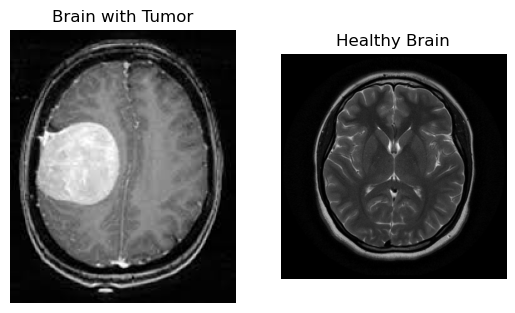

In [11]:
# Display a tumor image
plt.subplot(1, 2, 1)
tumor_img = Image.open(os.path.join(yes_path, os.listdir(yes_path)[0]))
plt.imshow(tumor_img, cmap='gray')
plt.title('Brain with Tumor')
plt.axis('off')

# Display a non-tumor image
plt.subplot(1, 2, 2)
no_tumor_img = Image.open(os.path.join(no_path, os.listdir(no_path)[0]))
plt.imshow(no_tumor_img, cmap='gray')
plt.title('Healthy Brain')
plt.axis('off')

plt.show()

In [13]:
# Preprocessing parameters
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32
TEST_SIZE = 0.2
VAL_SIZE = 0.2


In [15]:
# Create ImageDataGenerator for preprocessing and augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SIZE
)

In [17]:
# ## 4. CNN Model
# ### 4.1. Data Augmentation

In [19]:
demo_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

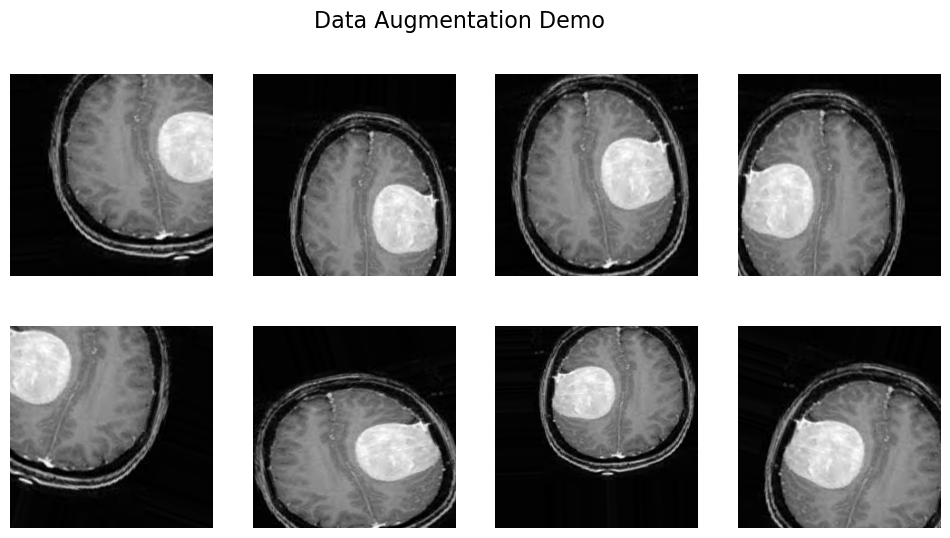

In [21]:
# Visualize augmented images
sample_img_path = os.path.join(yes_path, os.listdir(yes_path)[0])
sample_img = tf.keras.preprocessing.image.load_img(sample_img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
sample_img = tf.keras.preprocessing.image.img_to_array(sample_img)
sample_img = sample_img.reshape((1,) + sample_img.shape)

plt.figure(figsize=(12, 6))
plt.suptitle('Data Augmentation Demo', fontsize=16)

i = 0
for batch in demo_datagen.flow(sample_img, batch_size=1):
    plt.subplot(2, 4, i+1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(batch[0]))
    plt.axis('off')
    i += 1
    if i >= 8:
        break

plt.show()

In [23]:
#apply augmentation to our training data

# %%
# Create training and validation generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VAL_SIZE
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SIZE
)

# %%
# Create data generators
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)


Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [25]:
print("Class indices:", train_generator.class_indices)


Class indices: {'no': 0, 'yes': 1}


In [ ]:
# ### 4.2. Model Building

In [29]:
# Create CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# %%
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# %%
# Display model summary
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,244,929 (84.86 MB)

 Trainable params: 22,244,929 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Calculate steps per epoch and validation steps
steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps = val_generator.n // val_generator.batch_size

In [35]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.5792 - loss: 1.3459 - precision: 0.7166 - recall: 0.5891

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 731ms/step - accuracy: 0.5792 - loss: 1.3272 - precision: 0.7117 - recall: 0.5853 - val_accuracy: 0.7188 - val_loss: 0.6810 - val_precision: 0.9286 - val_recall: 0.6190
Epoch 2/30
1/6 ━━━━━━━━━━━━━━━━━━━━ 2s 536ms/step - accuracy: 0.5312 - loss: 0.6899 - precision: 0.6500 - recall: 0.6190

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.5312 - loss: 0.6899 - precision: 0.6500 - recall: 0.6190 - val_accuracy: 0.7500 - val_loss: 0.6735 - val_precision: 0.7200 - val_recall: 0.9474
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 663ms/step - accuracy: 0.6548 - loss: 0.6812 - precision: 0.6790 - recall: 0.8334 - val_accuracy: 0.6562 - val_loss: 0.6199 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7273 - loss: 0.6143 - precision: 0.7273 - recall: 1.0000 - val_accuracy: 0.6250 - val_loss: 0.6175 - val_precision: 0.6129 - val_recall: 1.0000
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 640ms/step - accuracy: 0.5569 - loss: 0.6749 - precision: 0.5586 - recall: 0.9663 - val_accuracy: 0.6250 - val_loss: 0.5913 - val_precision: 0.6129 - val_recall: 1.0000
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6250 - loss: 0.6456 - precision: 0.6452 - recall: 0.9524 - val_accuracy: 0.6562 - val_loss: 0.5513 - val_precision: 0

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.6562 - loss: 0.6347 - precision: 0.7778 - recall: 0.6667 - val_accuracy: 0.8125 - val_loss: 0.4914 - val_precision: 0.8095 - val_recall: 0.8947
Epoch 11/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 575ms/step - accuracy: 0.6134 - loss: 0.6545 - precision: 0.6721 - recall: 0.6203 - val_accuracy: 0.6562 - val_loss: 0.6428 - val_precision: 0.6333 - val_recall: 1.0000
Epoch 12/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7188 - loss: 0.5361 - precision: 0.7000 - recall: 1.0000 - val_accuracy: 0.5938 - val_loss: 0.7441 - val_precision: 0.5667 - val_recall: 1.0000
Epoch 13/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 576ms/step - accuracy: 0.6157 - loss: 0.6751 - precision: 0.6015 - recall: 0.9826 - val_accuracy: 0.8125 - val_loss: 0.4877 - val_precision: 0.7917 - val_recall: 0.9500
Epoch 14/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5938 - loss: 0.6550 - precision: 0.6957 - recall: 0.7273 - val_accuracy: 0.7500 - val_loss: 0.5587 - val_precisio

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.8182 - loss: 0.5091 - precision: 0.7500 - recall: 1.0000 - val_accuracy: 0.8438 - val_loss: 0.4626 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 17/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 621ms/step - accuracy: 0.6475 - loss: 0.6435 - precision: 0.6682 - recall: 0.7545 - val_accuracy: 0.7500 - val_loss: 0.6396 - val_precision: 0.7143 - val_recall: 1.0000
Epoch 18/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7812 - loss: 0.5357 - precision: 0.8636 - recall: 0.8261 - val_accuracy: 0.7500 - val_loss: 0.5602 - val_precision: 0.7333 - val_recall: 1.0000
Epoch 19/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 594ms/step - accuracy: 0.6688 - loss: 0.6042 - precision: 0.6543 - recall: 0.9776 - val_accuracy: 0.6875 - val_loss: 0.5033 - val_precision: 0.6552 - val_recall: 1.0000
Epoch 20/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7812 - loss: 0.6200 - precision: 0.7407 - recall: 1.0000 - val_accuracy: 0.8125 - val_loss: 0.5154 - val_precisio

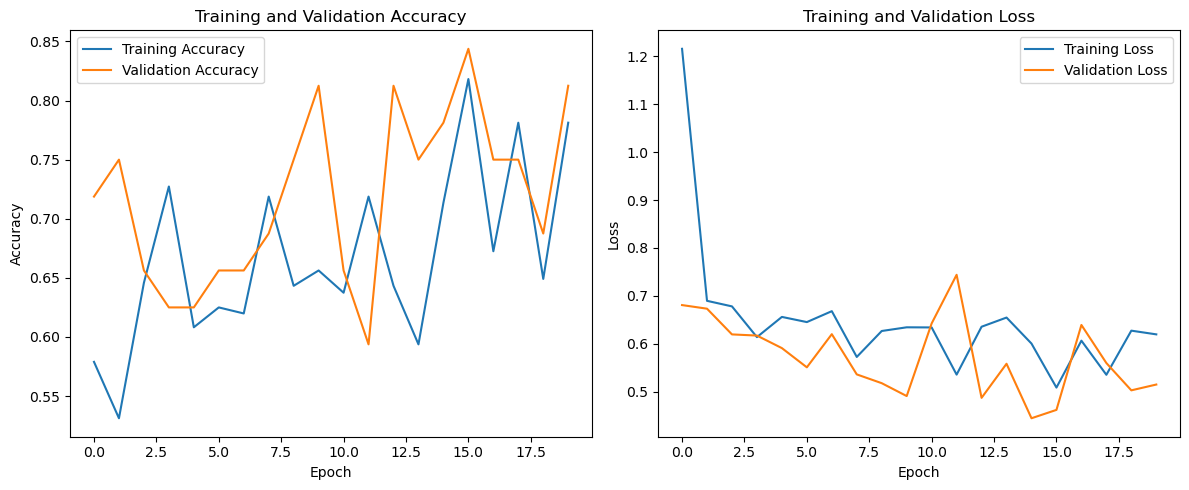

In [37]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

In [41]:
# Evaluate on validation set
val_loss, val_accuracy, val_precision, val_recall = best_model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Validation Precision: {val_precision*100:.2f}%")
print(f"Validation Recall: {val_recall*100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.7700 - loss: 0.5320 - precision: 0.7228 - recall: 1.0000
Validation Accuracy: 78.00%
Validation Precision: 73.81%
Validation Recall: 100.00%


In [43]:
# Create test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 253 images belonging to 2 classes.


In [45]:
# Predict on test set
y_pred = best_model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)
y_true = test_generator.classes


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


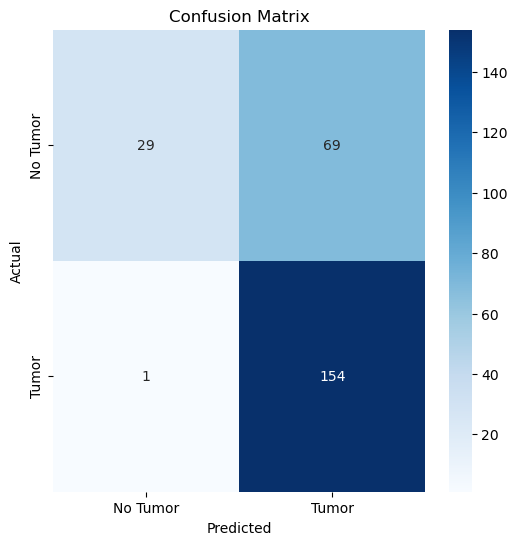

In [47]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Tumor', 'Tumor'], 
            yticklabels=['No Tumor', 'Tumor'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [49]:
# Classification report
print(classification_report(y_true, y_pred, target_names=['No Tumor', 'Tumor']))


              precision    recall  f1-score   support

    No Tumor       0.97      0.30      0.45        98
       Tumor       0.69      0.99      0.81       155

    accuracy                           0.72       253
   macro avg       0.83      0.64      0.63       253
weighted avg       0.80      0.72      0.67       253



In [51]:
# Save the final model
best_model.save('brain_tumor_detection_model.h5')
print("Model saved successfully!")

Model saved successfully!
